## Description of the dataset

| Column header | Unit of measure | Description |
|---------------|-----------------|-------------|
| n            | ms             | Timestamp of the recorded gaze sample since the beginning of the recording |
| x            | dva            | $\theta_h$ for the cyclopean eye |
| y            | dva            | $\theta_v$ for the cyclopean eye |
| lx           | dva            | $\theta_h$ for the left eye |
| ly           | dva            | $\theta_v$ for the left eye |
| rx           | dva            | $\theta_h$ for the right eye |
| ry           | dva            | $\theta_v$ for the right eye |
| xT*          | dva            | $\theta_h$ for the stimulus, relative to the cyclopean eye |
| yT*          | dva            | $\theta_v$ for the stimulus, relative to the cyclopean eye |
| zT           | m              | Depth of the stimulus |
| clx          | m              | X position of the center of the left eyeball, relative to the camera origin |
| cly          | m              | Y position of the center of the left eyeball, relative to the camera origin |
| clz          | m              | Z position of the center of the left eyeball, relative to the camera origin |
| crx          | m              | X position of the center of the right eyeball, relative to the camera origin |
| cry          | m              | Y position of the center of the right eyeball, relative to the camera origin |
| crz          | m              | Z position of the center of the right eyeball, relative to the camera origin |
| round        |                | recording round (1-3) |
| participant  |                | participant ID (001-465) |
| session      |                | recording session (1-2) |
| task         |                | task category (1-5) |

In [5]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset using Dask with specified dtypes

df = dd.read_parquet('dataset/gazebasevr.parquet')


# Print memory usage

print(f"{df.memory_usage().sum().compute() / 1024 ** 2:.2f} MB")

7286.99 MB


In [2]:
# Describe the dataset
print(df.dtypes)

n              float64
x              float32
y              float32
lx             float32
ly             float32
rx             float32
ry             float32
xT             float32
yT             float32
zT             float32
clx            float32
cly            float32
clz            float32
crx            float32
cry            float32
crz            float32
round             int8
participant      int16
session           int8
task              int8
dtype: object


In [8]:
# Shape of the dataset (rows, columns)
print((df.size.compute() // 20, 20))

(104670655, 20)


In [3]:
# Map from task id (1-5) to task name (VRG, PUR, VID, TEX, RAN)
task_map = {
    1: 'VRG',
    2: 'PUR',
    3: 'VID',
    4: 'TEX',
    5: 'RAN'
}

In [4]:
# Preview the dataset
df.head()

,n,x,y,lx,ly,rx,ry,xT,yT,zT,clx,cly,clz,crx,cry,crz,round,participant,session,task
0,0.0000,0.7334,-4.9397,3.5087,-4.3093,-2.0631,-5.1669,0.0,0.0,0.4433,-0.0322,0.0028,-0.0294,0.0325,0.004,-0.0302,1,2,1,1
1,3.9699,0.7391,-4.9568,3.7095,-4.7536,-2.0802,-5.4778,0.0,0.0,0.4433,-0.0322,0.0029,-0.0294,0.0325,0.004,-0.0303,1,2,1,1
2,7.9582,0.7391,-4.9454,3.5432,-4.3498,-2.0860,-5.4031,0.0,0.0,0.4433,-0.0322,0.0028,-0.0293,0.0325,0.004,-0.0302,1,2,1,1
3,11.9413,0.7506,-4.9511,3.7038,-4.6902,-2.0688,-5.4778,0.0,0.0,0.4433,-0.0322,0.0029,-0.0293,0.0325,0.004,-0.0302,1,2,1,1
4,15.9812,0.7506,-4.9454,3.4626,-4.4529,-2.1319,-5.5126,0.0,0.0,0.4433,-0.0322,0.0029,-0.0293,0.0325,0.004,-0.0302,1,2,1,1


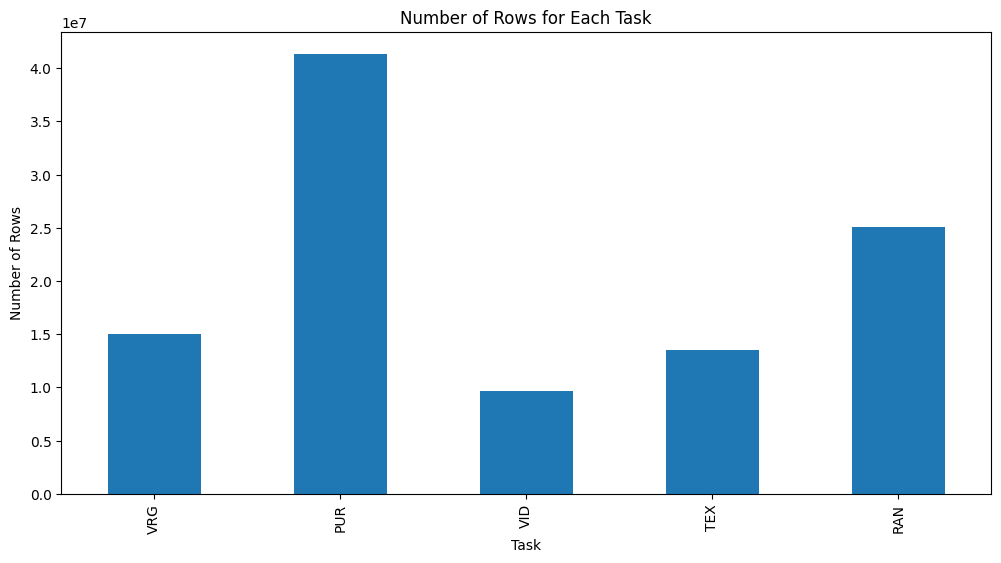

In [ ]:
# Number of rows for each task
rows_per_task = df['task'].value_counts().compute()

# Map task id to task name
rows_per_task.index = rows_per_task.index.map(task_map)

# Plot the number of rows for each task
plt.figure(figsize=(12, 6))
rows_per_task.plot(kind='bar')
plt.title('Number of Rows for Each Task')
plt.xlabel('Task')
plt.ylabel('Number of Rows')
plt.show()

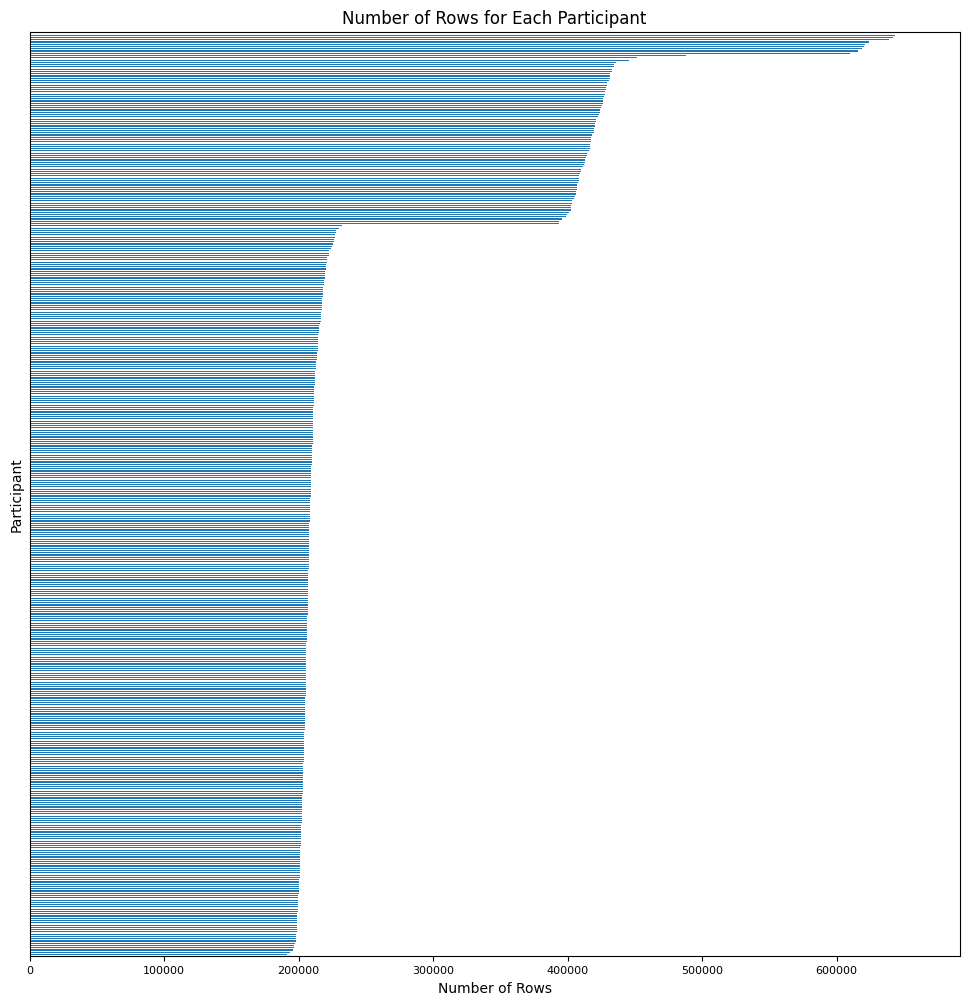

In [11]:
# Number of rows for each participant
rows_per_participant = df["participant"].value_counts().compute()

# Plot the number of rows for each participant using a horizontal bar plot
plt.figure(figsize=(12, 12))
rows_per_participant.sort_values().plot(kind="barh", fontsize=8)
plt.title("Number of Rows for Each Participant")
plt.xlabel("Number of Rows")
plt.ylabel("Participant")
plt.yticks([])  # Hide participant labels
plt.show()

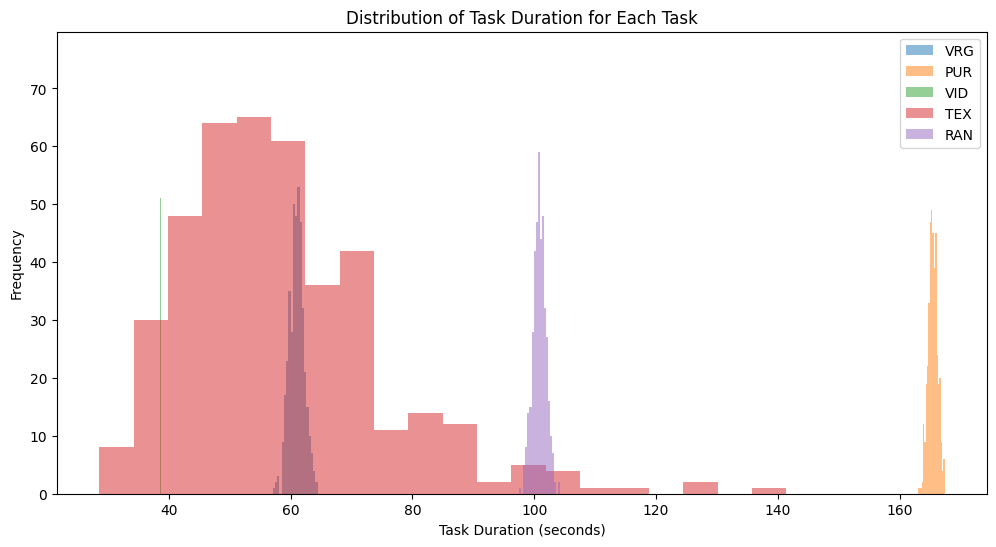

In [23]:
# Calculate task duration for each participant and task
task_duration = (df.groupby(['participant', 'task'])['n'].max().compute() - df.groupby(['participant', 'task'])['n'].min().compute()) / 1000

# Map task id to task name
task_duration.index = task_duration.index.set_levels(task_duration.index.levels[1].map(task_map), level=1)

# Plot the distribution of task duration for each task
plt.figure(figsize=(12, 6))
for i, task in enumerate(task_duration.index.get_level_values('task').unique()):
    plt.hist(task_duration[task_duration.index.get_level_values('task') == task], bins=20, alpha=0.5, label=task)

plt.title('Distribution of Task Duration for Each Task')
plt.xlabel('Task Duration (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Calculate the percentage of missing values for each column grouped by task
missing_data_by_task = df.groupby('task').apply(lambda x: x.isnull().mean() * 100).compute()

# Map task id to task name
missing_data_by_task.index = missing_data_by_task.index.map(task_map)

<Figure size 1200x800 with 0 Axes>

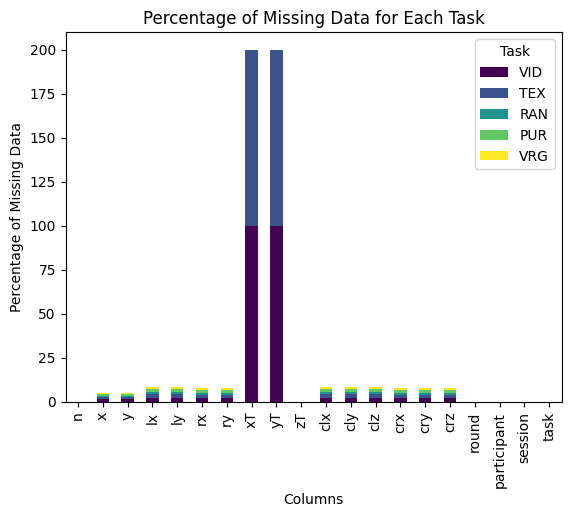

In [6]:
# Plot the missing data percentage for each task
plt.figure(figsize=(12, 8))
missing_data_by_task.T.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Percentage of Missing Data for Each Task")
plt.xlabel("Columns")
plt.ylabel("Percentage of Missing Data")
plt.legend(title="Task")
plt.show()